#  VESTA


In [1]:
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve

from sklearn import metrics
from sklearn import preprocessing
import catboost
from catboost import Pool

# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

#Timer
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken for Modeling: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## DATASETS

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')

CPU times: user 26.2 s, sys: 3.28 s, total: 29.5 s
Wall time: 34.3 s


## MERGE, MISSING VALUE, FILL NA

In [3]:
# merge 
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)

print("Train shape : "+str(train_df.shape))

Train shape : (590540, 433)


In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
# GPreda, missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [6]:
display(missing_data(train_df))

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,76022,279287,525823,528588,528353,89113,271100,271100,271100,281444,350482,169360,346265,346252,346252,279287,279287,279287,279287,279287,279287,279287,279287,279287,279287,279287,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,508595,508595,508595,508595,508595,508589,508589,508589,508595,508595,508595,508595,508589,508589,508589,508595,508595,508595,508595,508595,508595,508589,508589,508595,508595,508595,508589,508589,508589,450909,450909,450721,450721,450721,450909,450909,450721,450721,450909,450909,450909,450909,450721,450909,450909,450909,450721,450721,450909,450909,450721,450721,450909,450909,450909,450909,450721,450721,450909,450721,450721,450909,450721,450721,450909,450909,450909,450909,450909,450909,450721,450721,450721,450909,450909,450909,450909,450909,450909,460110,460110,460110,449124,449124,449124,460110,460110,460110,460110,449124,460110,460110,460110,460110,460110,460110,449124,460110,460110,460110,449124,449124,460110,460110,460110,460110,460110,449124,460110,460110,460110,460110,449124,449124,460110,460110,460110,449124,449124,460110,460110,449124,460110,4601

In [7]:
#fillna
train_df = train_df.fillna(-999)

In [8]:
del train_transaction, train_identity

## ENCODING

In [9]:
# Label Encoding
for f in train_df.columns:
    if  train_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values)) 
train_df = train_df.reset_index()

In [10]:
from sklearn.model_selection import train_test_split 

train_df , test_df = train_test_split(train_df, test_size = 0.25)

In [11]:
features = list(train_df)
features.remove('isFraud')
target = 'isFraud'

## CONFUSION MATRIX

In [12]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#  Catboost

## PARAMS 

In [13]:
param_cb = {
        'learning_rate': 0.2,
        'bagging_temperature': 0.1, 
        'l2_leaf_reg': 30,
        'depth': 12, 
        'max_leaves': 48,
        'max_bin':255,
        'iterations' : 1000,
        'task_type':'GPU',
        'loss_function' : "Logloss",
        'objective':'CrossEntropy',
        'eval_metric' : "AUC",
        'bootstrap_type' : 'Bayesian',
        'random_seed':1337,
        'early_stopping_rounds' : 100,
        'use_best_model': True 
}

## CV 5 FOLDS AND METRICS

CatBoost GPU modeling...

fold 1
0:	learn: 0.7871521	test: 0.7972387	best: 0.7972387 (0)	total: 165ms	remaining: 2m 44s
300:	learn: 0.9711149	test: 0.9450475	best: 0.9450475 (300)	total: 44.8s	remaining: 1m 44s
600:	learn: 0.9860464	test: 0.9539191	best: 0.9539738 (599)	total: 1m 28s	remaining: 59s
900:	learn: 0.9941470	test: 0.9595250	best: 0.9595371 (899)	total: 2m 13s	remaining: 14.7s
999:	learn: 0.9952844	test: 0.9601760	best: 0.9601760 (999)	total: 2m 27s	remaining: 0us
bestTest = 0.9601759911
bestIteration = 999
Shrink model to first 1000 iterations.

fold 2
0:	learn: 0.7893708	test: 0.7880874	best: 0.7880874 (0)	total: 159ms	remaining: 2m 38s
300:	learn: 0.9692293	test: 0.9454343	best: 0.9454343 (300)	total: 45.1s	remaining: 1m 44s
600:	learn: 0.9865377	test: 0.9553066	best: 0.9553066 (600)	total: 1m 29s	remaining: 59.5s
900:	learn: 0.9924885	test: 0.9602565	best: 0.9602584 (898)	total: 2m 14s	remaining: 14.8s
999:	learn: 0.9937155	test: 0.9611590	best: 0.9611590 (999)	total: 2m

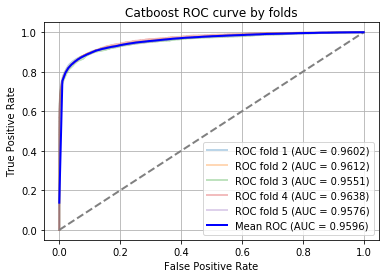

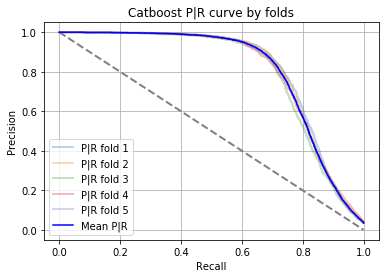

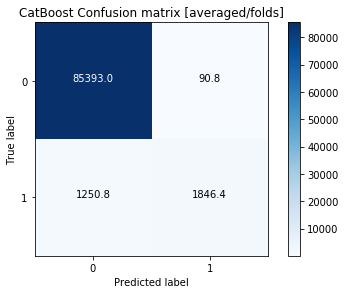

In [14]:
print('CatBoost GPU modeling...')
start_time = timer(None)
plt.rcParams["axes.grid"] = True

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = Pool(train_df.iloc[train_idx][features].values,
                   label=train_df.iloc[train_idx][target].values
                   )
    val_data = Pool(train_df.iloc[valid_idx][features].values,
                   label=train_df.iloc[valid_idx][target].values
                   )   

    clf = catboost.train(trn_data, param_cb, eval_set= val_data, verbose = 300)

    oof[valid_idx]  = clf.predict(train_df.iloc[valid_idx][features].values)   
    oof[valid_idx]  = np.exp(oof[valid_idx]) / (1 + np.exp(oof[valid_idx]))
    
    predictions += clf.predict(test_df[features]) / nfold
    predictions = np.exp(predictions)/(1 + np.exp(predictions))
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by fold
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))

    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.get_feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Catboost ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Catboost P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'CatBoost Confusion matrix [averaged/folds]')
# Timer end    
timer(start_time)

#  Feature importance

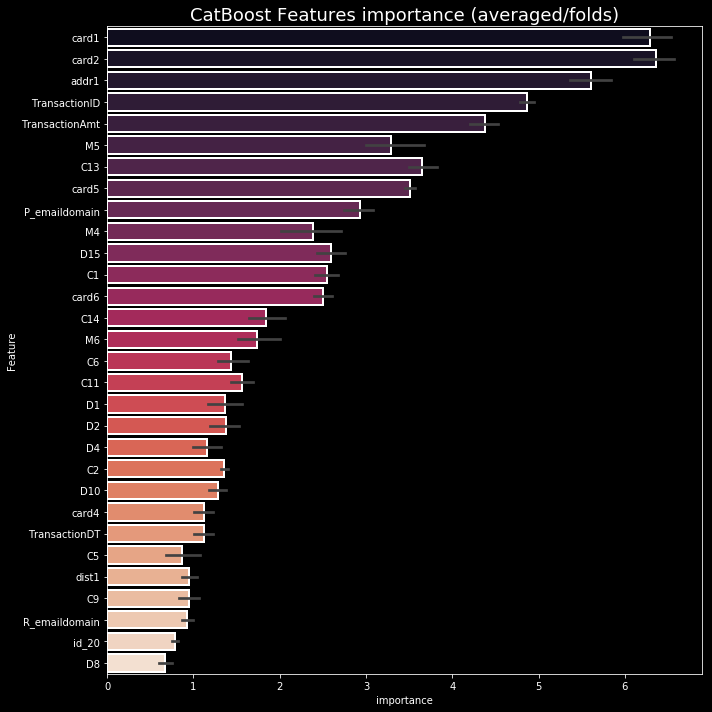

In [15]:
plt.style.use('dark_background')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('CatBoost Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [24]:
print("training f1 score {}".format(np.mean(f1_scores)))
print("test f1 score {}".format(f1_score(test_df[target].values, predictions.round())))

training f1 score 0.7334509227701995
test f1 score 0.7028301886792453


# Random Forest

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [27]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

In [29]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

In [30]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [32]:
grid_rfc.fit(train_df[features], train_df[target])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=False,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                          

In [34]:
train_pred = grid_rfc.predict(train_df[features])
test_pred = grid_rfc.predict(test_df[features])

In [36]:
print("training f1 score {}".format(f1_score(train_df[target].values, train_pred.round())))
print("test f1 score {}".format(f1_score(test_df[target].values, test_pred.round())))

training f1 score 0.9970856809792111
test f1 score 0.6074423480083858


# XGBoost

In [12]:
from xgboost import XGBClassifier
import time

In [15]:
start = time.time()
from xgboost import XGBClassifier

# XGBoost
classifier_xgb = XGBClassifier(tree_method='gpu_hist')

# Randomly search the hyperparameter space
parameters = {

    'min_child_weight':(0,0.1,1,10,100,500),
    'learning_rate':(0.01, 0.1,1),
    'min_split_loss':(0,0.01,0.1,1),
    'max_depth':(2,6,8,10,12),
    'lambda':(0.1,1,2,5,10)
}
Random_XGB = RandomizedSearchCV(classifier_xgb,parameters, cv=5)
Random_XGB.fit(train_df[features], train_df[target])
elapsed = time.time() - start
print(elapsed)

591.8933081626892


In [16]:
train_pred = Random_XGB.predict(train_df[features])
test_pred = Random_XGB.predict(test_df[features])

In [17]:
print("training f1 score {}".format(f1_score(train_df[target].values, train_pred.round())))
print("test f1 score {}".format(f1_score(test_df[target].values, test_pred.round())))

training f1 score 0.999935375468528
test f1 score 0.7615834457939721


# Light BGM

In [22]:
import lightgbm as lgb
import random

random.seed(2020)

In [23]:
# Use grid search and 5 fold cross validation to find the best model
start = time.time()
parameters = {
    "n_estimators": (50, 100, 200),
    "max_depth" : (5,),
    "reg_lambda" : (0.1,0.01)
}
model_lgb =lgb.LGBMClassifier(eval_metric = "auc")
Grid_lgbm = GridSearchCV(model_lgb,parameters, cv=5,  scoring = "roc_auc")

In [24]:
Grid_lgbm.fit(train_df[features], train_df[target])
elapsed = time.time() - start
print(elapsed)

2853.6676161289215


In [25]:
train_pred = Grid_lgbm.predict(train_df[features])
test_pred = Grid_lgbm.predict(test_df[features])

In [26]:
print("training f1 score {}".format(f1_score(train_df[target].values, train_pred.round())))
print("test f1 score {}".format(f1_score(test_df[target].values, test_pred.round())))

training f1 score 0.6108477230220521
test f1 score 0.5683262711864406
